In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [2]:
video_games_sales = pd.read_csv('../data/raw/vgsales.csv')
video_games_sales.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [3]:
video_games_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [4]:
missing_data = video_games_sales.isnull().sum()
print(missing_data)

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64


In [5]:
video_games_sales.ffill(inplace=True)
missing_data = video_games_sales.isnull().sum()
print(missing_data)

Rank            0
Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64


In [6]:
video_games_sales.Year = video_games_sales.Year.astype(int)
video_games_sales.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


## Global Sales Analysis

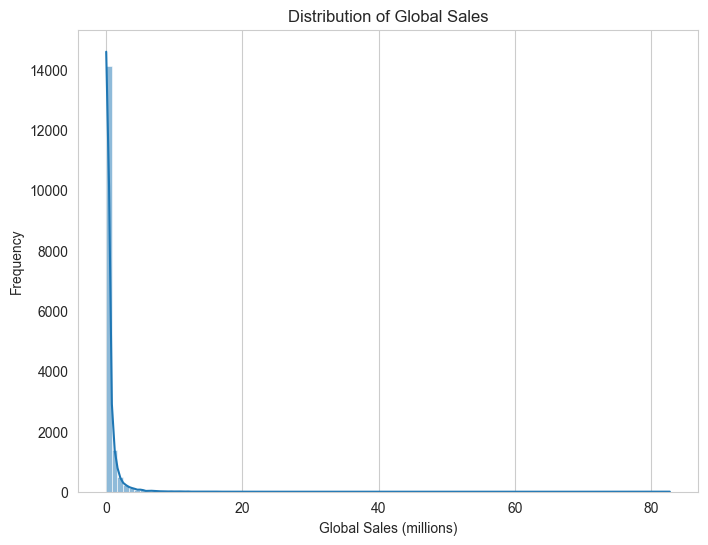

In [7]:
plt.figure(figsize=(8, 6))
sns.histplot(video_games_sales['Global_Sales'], bins=100, kde=True)
plt.title('Distribution of Global Sales')
plt.xlabel('Global Sales (millions)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

In [8]:
skewed_features = ['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
for feature in skewed_features:
    video_games_sales[feature] = np.log1p(video_games_sales[feature])  # Apply log(1+x) transformation

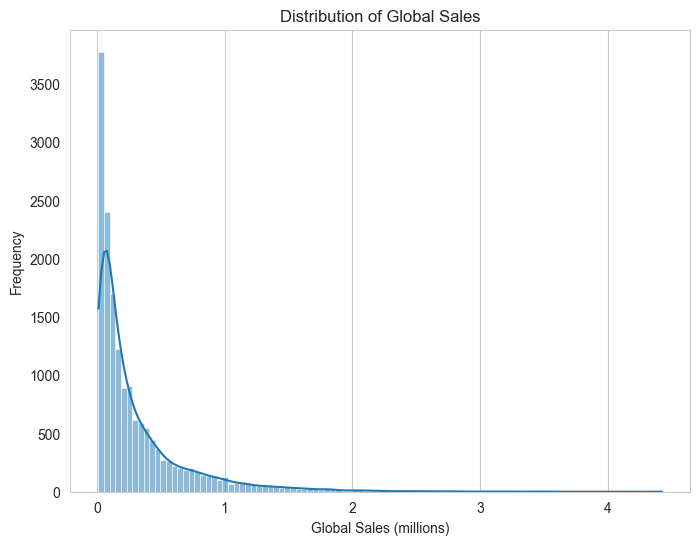

In [9]:
plt.figure(figsize=(8, 6))
sns.histplot(video_games_sales['Global_Sales'], bins=100, kde=True)
plt.title('Distribution of Global Sales')
plt.xlabel('Global Sales (millions)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

## Time Series Analysis

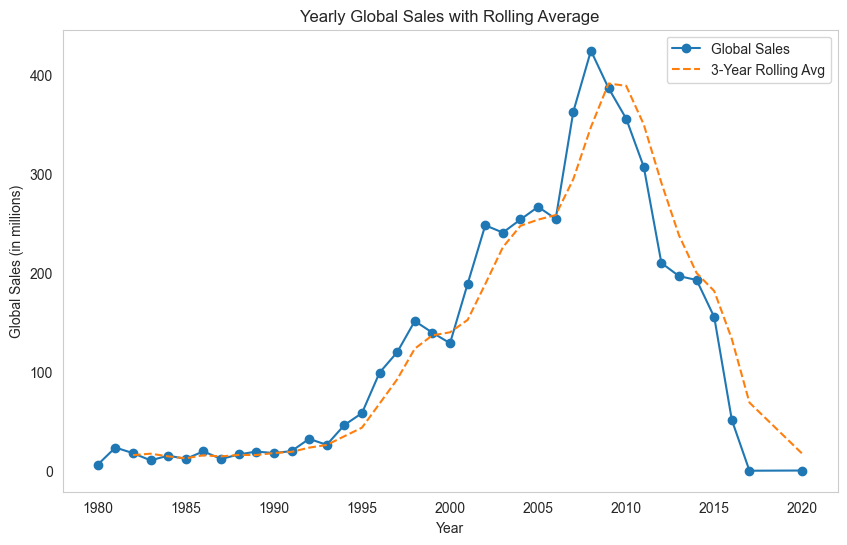

In [10]:
yearly_sales = video_games_sales.groupby('Year')['Global_Sales'].sum().reset_index()
yearly_sales['Rolling_Avg'] = yearly_sales['Global_Sales'].rolling(window=3).mean()

plt.figure(figsize=(10, 6))
plt.plot(yearly_sales['Year'], yearly_sales['Global_Sales'], marker='o', label='Global Sales')
plt.plot(yearly_sales['Year'], yearly_sales['Rolling_Avg'], label='3-Year Rolling Avg', linestyle='--')
plt.title('Yearly Global Sales with Rolling Average')
plt.xlabel('Year')
plt.ylabel('Global Sales (in millions)')
plt.grid()
plt.legend()
plt.show()


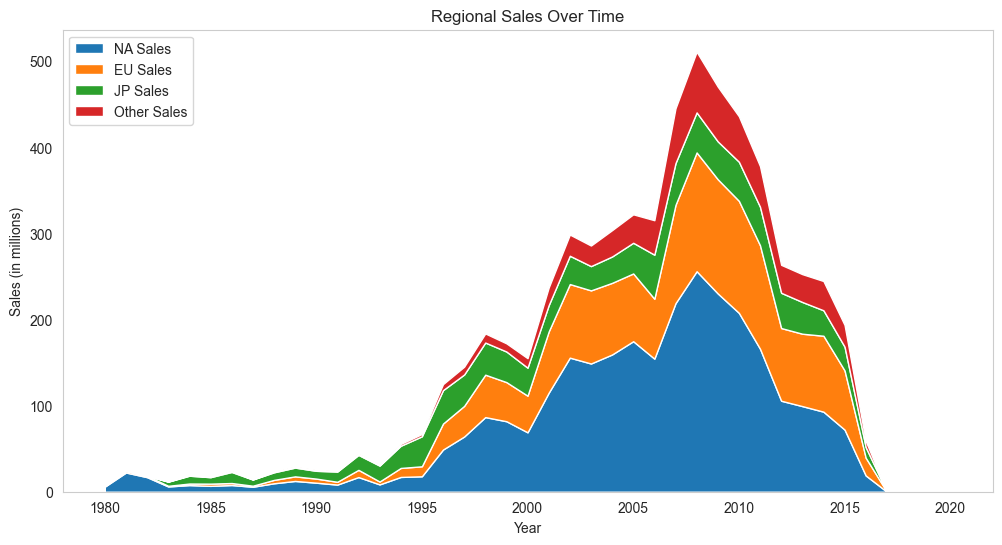

In [11]:
regional_sales = video_games_sales.groupby('Year')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.stackplot(
    regional_sales['Year'], 
    regional_sales['NA_Sales'], 
    regional_sales['EU_Sales'], 
    regional_sales['JP_Sales'], 
    regional_sales['Other_Sales'], 
    labels=['NA Sales', 'EU Sales', 'JP Sales', 'Other Sales']
)
plt.title('Regional Sales Over Time')
plt.xlabel('Year')
plt.ylabel('Sales (in millions)')
plt.legend(loc='upper left')
plt.grid()
plt.show()


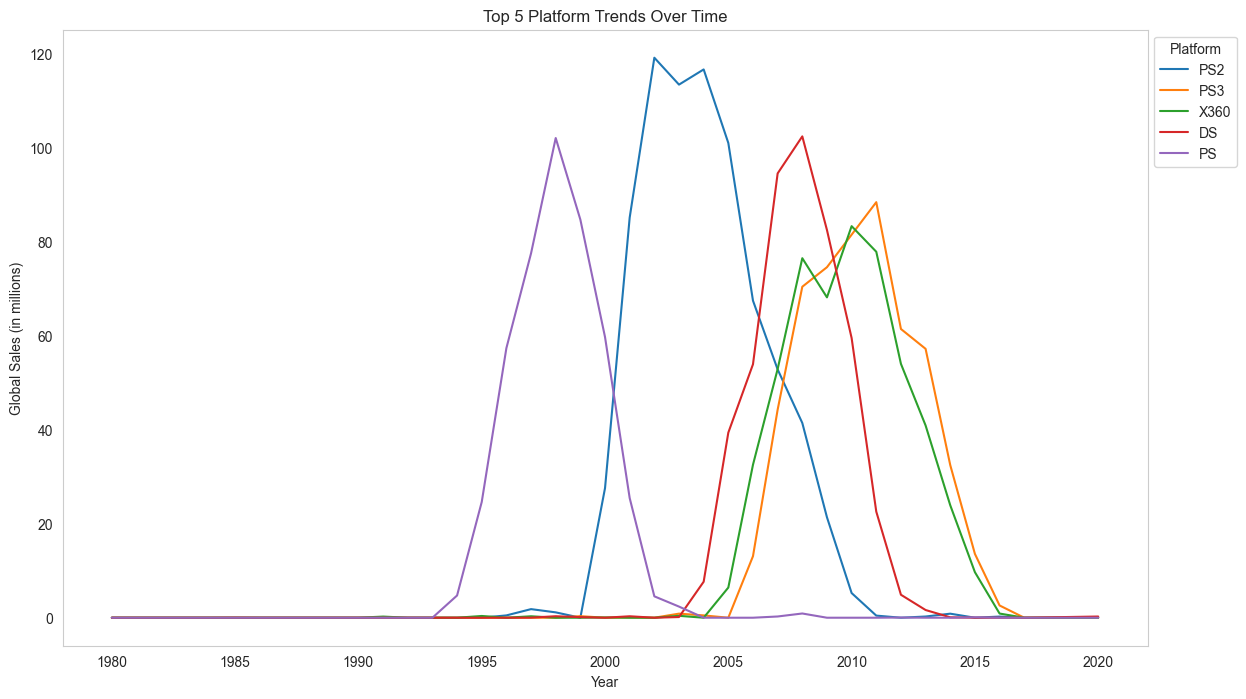

In [12]:
platform_trends = video_games_sales.groupby(['Year', 'Platform'])['Global_Sales'].sum().reset_index()
platform_pivot = platform_trends.pivot(index='Year', columns='Platform', values='Global_Sales').fillna(0)
total_sales_per_platform = platform_pivot.sum(axis=0)
top_5_platforms = total_sales_per_platform.nlargest(5).index
top_5_platform_pivot = platform_pivot[top_5_platforms]
plt.figure(figsize=(14, 8))
for platform in top_5_platform_pivot.columns:
    plt.plot(top_5_platform_pivot.index, top_5_platform_pivot[platform], label=platform)

plt.title('Top 5 Platform Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Global Sales (in millions)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Platform')
plt.grid()
plt.show()

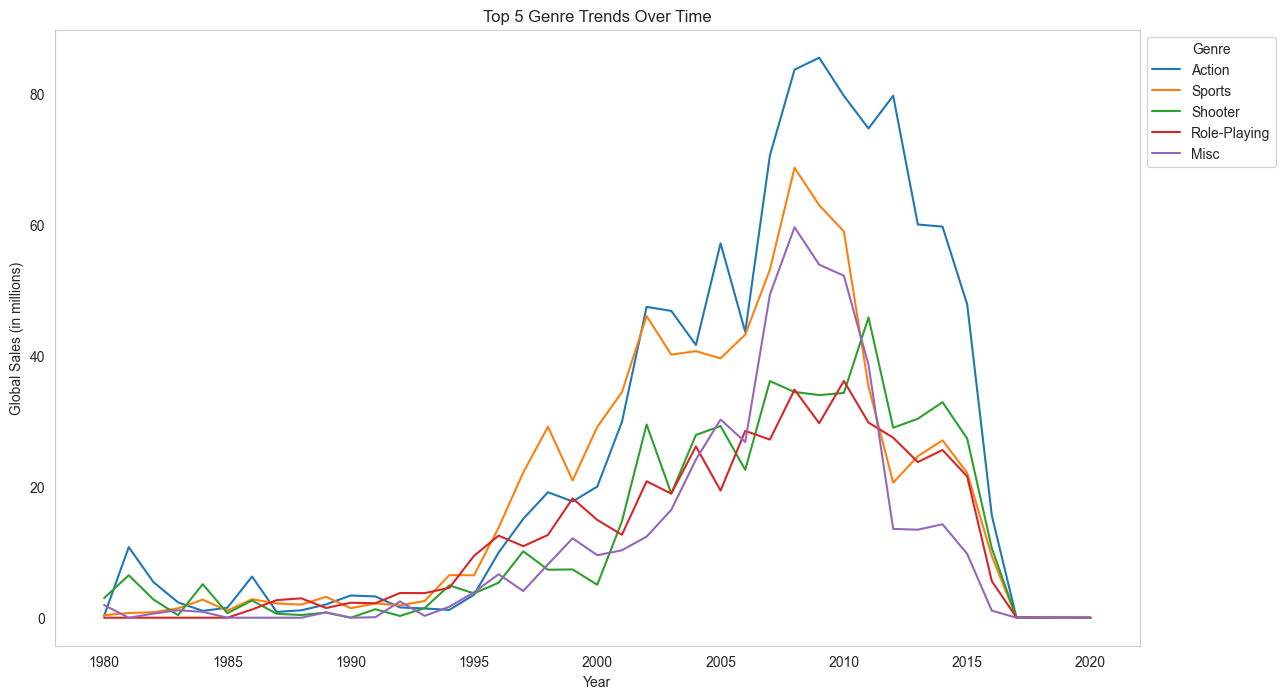

In [13]:
genre_trends = video_games_sales.groupby(['Year', 'Genre'])['Global_Sales'].sum().reset_index()
genre_pivot = genre_trends.pivot(index='Year', columns='Genre', values='Global_Sales').fillna(0)
total_sales_per_genre = genre_pivot.sum(axis=0)
top_5_genres = total_sales_per_genre.nlargest(5).index
top_5_genre_pivot = genre_pivot[top_5_genres]
plt.figure(figsize=(14, 8))
for genre in top_5_genre_pivot.columns:
    plt.plot(top_5_genre_pivot.index, top_5_genre_pivot[genre], label=genre)

plt.title('Top 5 Genre Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Global Sales (in millions)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Genre')
plt.grid()
plt.show()

## Genre Analysis

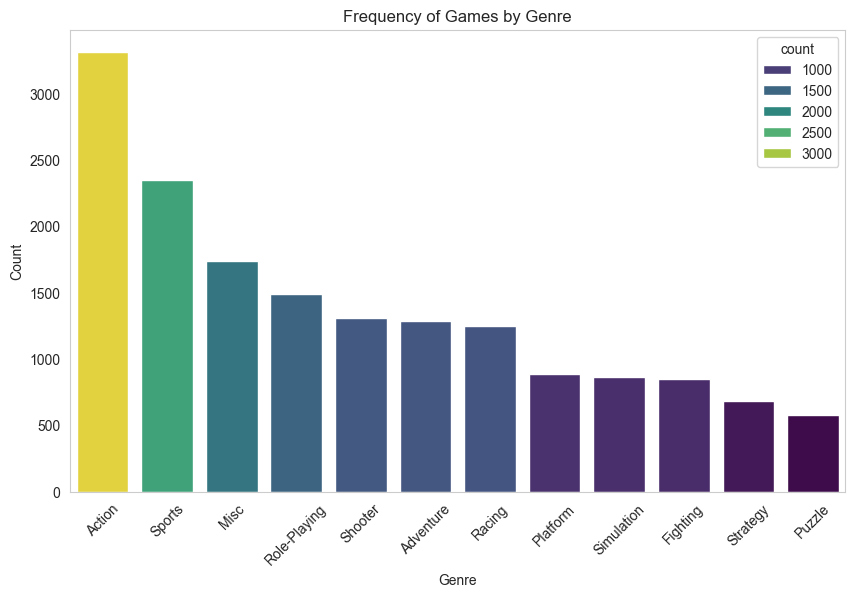

In [14]:
plt.figure(figsize=(10, 6))
genre_counts = video_games_sales['Genre'].value_counts()
sns.barplot(x=genre_counts.index, y=genre_counts.values,hue=genre_counts,palette="viridis")
plt.title('Frequency of Games by Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

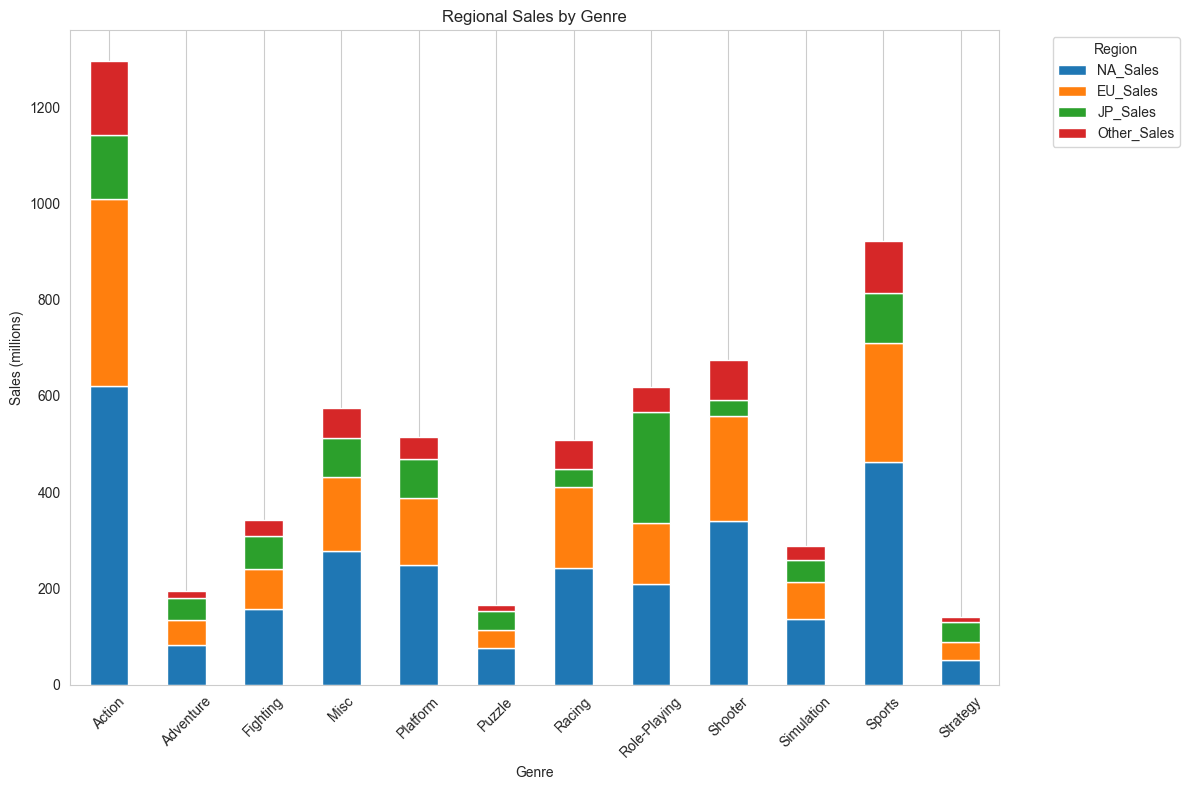

In [15]:
# Total Regional Sales by Genre
regional_sales = video_games_sales.groupby('Genre')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()

regional_sales.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Regional Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Sales (millions)')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


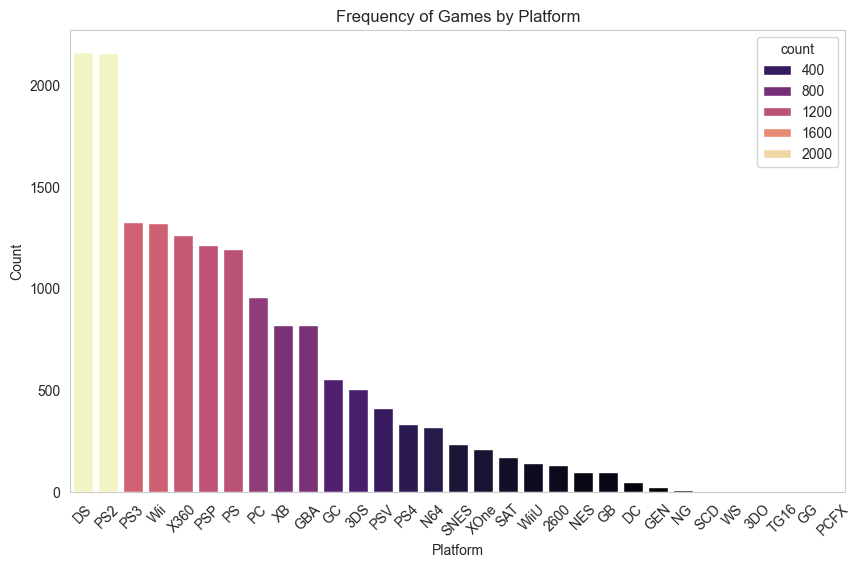

In [16]:
plt.figure(figsize=(10, 6))
platform_counts = video_games_sales['Platform'].value_counts()
sns.barplot(x=platform_counts.index, y=platform_counts.values,hue=platform_counts,palette="magma")
plt.title('Frequency of Games by Platform')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

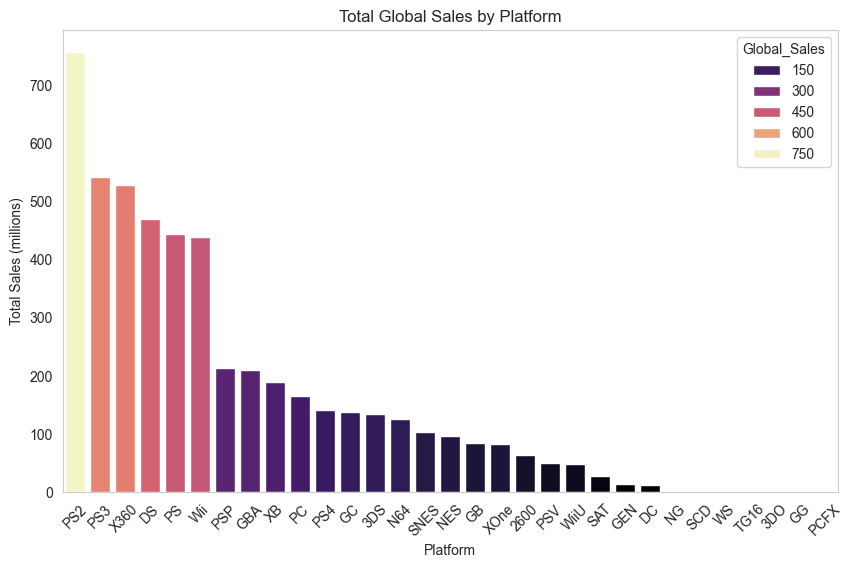

In [17]:
# Total Global Sales by Platform
platform_sales = video_games_sales.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=platform_sales.index, y=platform_sales.values,hue=platform_sales,palette="magma")
plt.title('Total Global Sales by Platform')
plt.xlabel('Platform')
plt.ylabel('Total Sales (millions)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


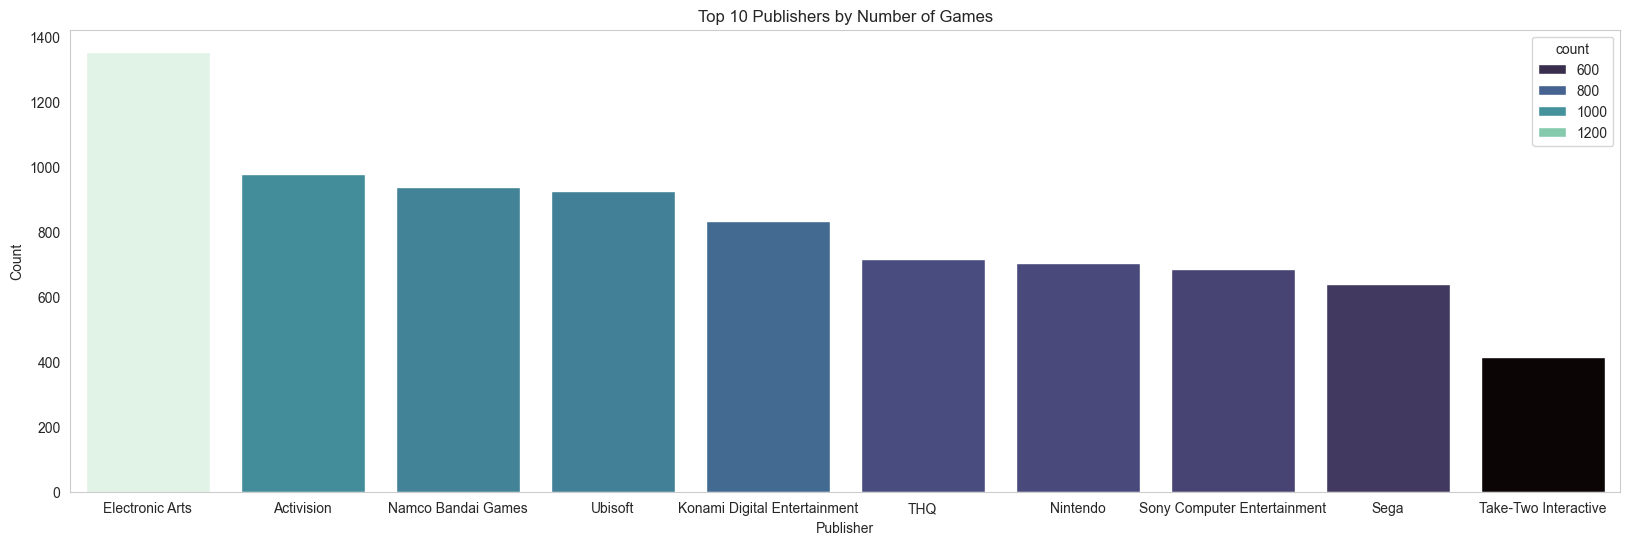

In [18]:
plt.figure(figsize=(20, 6))
publisher_counts = video_games_sales['Publisher'].value_counts().head(10)
sns.barplot(x=publisher_counts.index, y=publisher_counts.values,hue=publisher_counts,palette="mako")
plt.title('Top 10 Publishers by Number of Games')
plt.xlabel('Publisher')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

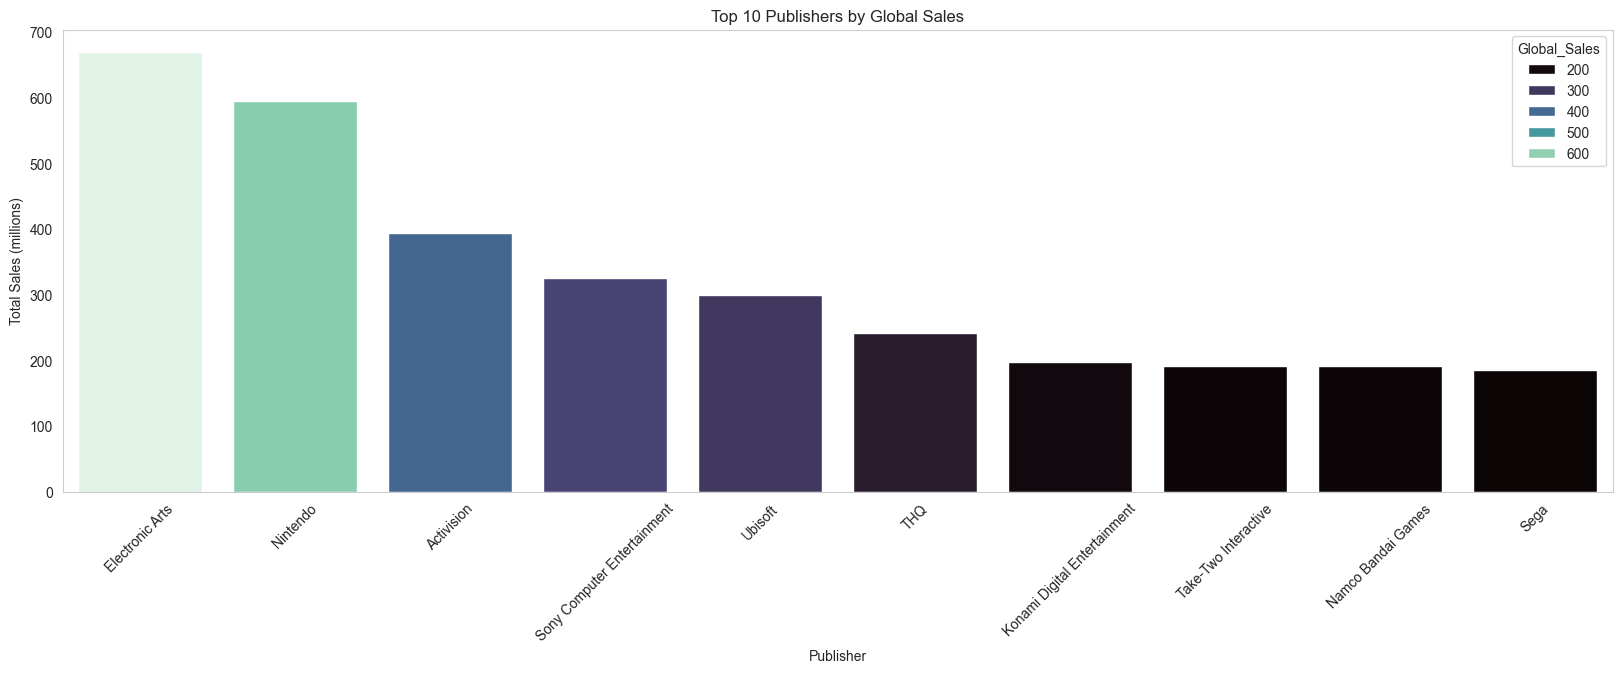

In [19]:
# Top 5 Publishers by Global Sales
top_publishers = video_games_sales.groupby('Publisher')['Global_Sales'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(20, 6))
sns.barplot(x=top_publishers.index, y=top_publishers.values,hue=top_publishers,palette="mako")
plt.title('Top 10 Publishers by Global Sales')
plt.xlabel('Publisher')
plt.ylabel('Total Sales (millions)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


## Linear Regression

### Feature Selection

In [20]:
from sklearn.calibration import LabelEncoder
vgs_transformed = video_games_sales.copy()

# Label encode the 'Platform' column
label_encoder = LabelEncoder()
vgs_transformed['Platform'] = label_encoder.fit_transform(video_games_sales['Platform'])
vgs_transformed['Genre'] = label_encoder.fit_transform(video_games_sales['Genre'])
vgs_transformed['Publisher'] = label_encoder.fit_transform(video_games_sales['Publisher'])
vgs_transformed.drop(columns="Name",inplace=True)
vgs_transformed

,Rank,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,26,2006,10,359,3.749269,3.401864,1.562346,2.247072,4.427717
1,2,11,1985,4,359,3.403860,1.521699,2.055405,0.570980,3.719409
2,3,26,2008,6,359,2.824351,2.630449,1.566530,1.460938,3.606041
3,4,26,2009,10,359,2.818398,2.485740,1.453953,1.376244,3.526361
4,5,5,1996,7,359,2.507157,2.291524,2.417698,0.693147,3.477232
...,...,...,...,...,...,...,...,...,...,...
16593,16596,6,2002,4,269,0.009950,0.000000,0.000000,0.000000,0.009950
16594,16597,7,2003,8,241,0.009950,0.000000,0.000000,0.000000,0.009950
16595,16598,16,2008,6,21,0.000000,0.000000,0.000000,0.000000,0.009950
16596,16599,4,2010,5,8,0.000000,0.009950,0.000000,0.000000,0.009950


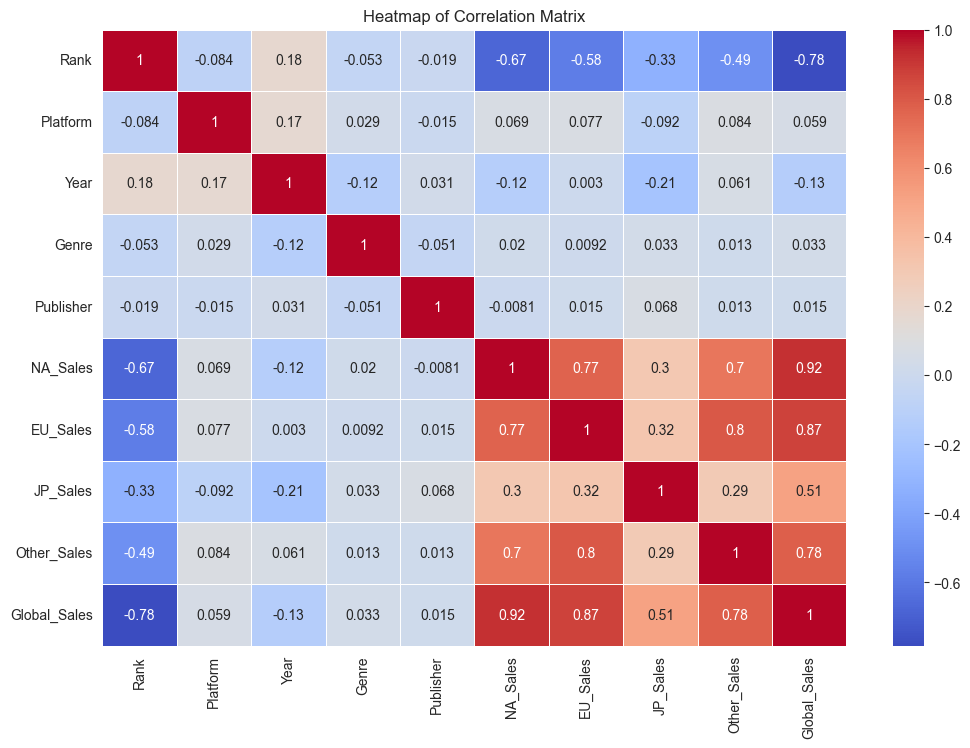

In [21]:
plt.figure(figsize=(12, 8))
correlation_matrix = vgs_transformed.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [22]:
selected_features = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
X = video_games_sales[selected_features]
y = video_games_sales["Global_Sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.006369779114774902
Mean Absolute Error (MAE): 0.05471144030692995
R² Score: 0.9554695078613014


In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=12)
mse_scores = []
mae_scores = []
r2_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse_scores.append(mean_squared_error(y_test, y_pred))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

print(f"Average Mean Squared Error (MSE): {np.mean(mse_scores)}")
print(f"Average Mean Absolute Error (MAE): {np.mean(mae_scores)}")
print(f"Average R² Score: {np.mean(r2_scores)}")


Average Mean Squared Error (MSE): 0.007393319109164619
Average Mean Absolute Error (MAE): 0.05367873955074337
Average R² Score: 0.9530459774435313


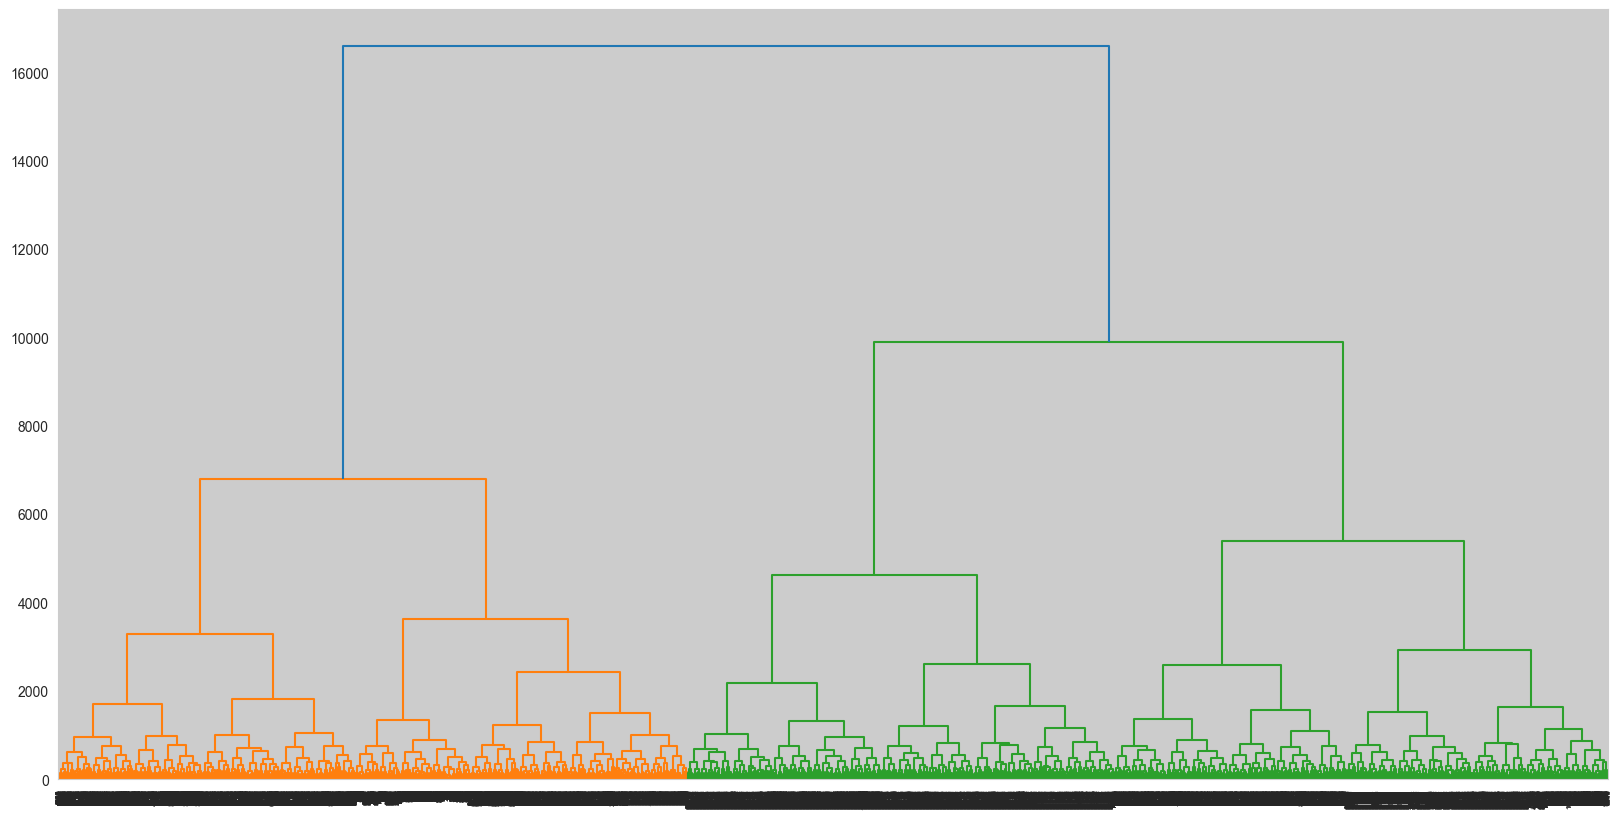

In [24]:
hierarchical_clustering = vgs_transformed
pca = PCA(n_components=2)
hc_pca = pca.fit_transform(hierarchical_clustering)
hc_complete = hierarchy.complete(hc_pca)
fig = plt.figure(figsize=(20, 10))
dn = hierarchy.dendrogram(hc_complete)
plt.show()

Text(0.5, 1.0, 'Silhouette Score vs Number of Clusters')

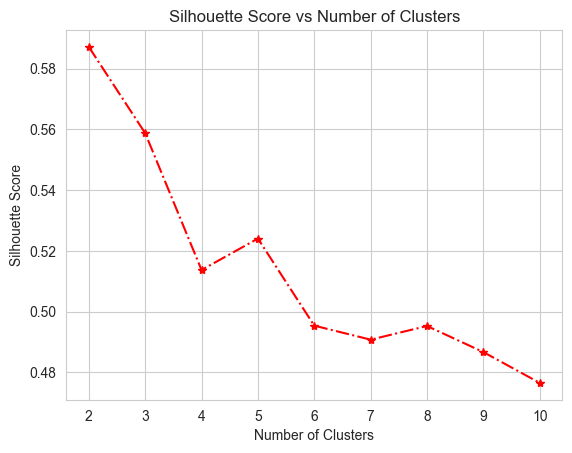

In [25]:
ss= []
k_range=range(2,11)
k_means = [AgglomerativeClustering(n_clusters=k).fit(hierarchical_clustering.values) for k in k_range]
sscores = [silhouette_score(hierarchical_clustering.values, kmean.labels_) for kmean in k_means]

plt.plot(list(k_range), sscores, 'r*-.')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")